In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import argparse
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [2]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import seaborn as sns

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

In [4]:
import tensorflow as tf

In [5]:
tf.enable_eager_execution()

In [6]:
def load_pep_and_codify(file, max_len):
    aa_dict={'A':1,'R':2,'N':3,'D':4,'C':5,'Q':6,'E':7,'G':8,'H':9,'I':10,'L':11,'K':12,'M':13,'F':14,
        'P':15,'O':16,'S':17,'U':18,'T':19,'W':20,'Y':21,'V':22}
    with open(file, 'r') as inf:
        lines = inf.read().splitlines()
    pep_codes=[]
    long_pep_counter = 0
    newLines = []
    for pep in lines:
        if not len(pep) > max_len:
            current_pep=[]
            for aa in pep:
                current_pep.append(aa_dict[aa])
            pep_codes.append(current_pep)
            newLines.extend([pep])
        else:
            long_pep_counter += 1
    predict_data = keras.preprocessing.sequence.pad_sequences(pep_codes, value=0, padding='post', maxlen=max_len)
    return predict_data, long_pep_counter, newLines

# 1. Make Data X_train, y_train, X_test, y_test

In [7]:
file_path = 'compareModel/2019Bioinformatics_DeepMSPeptide/DeepMSPeptide/'

In [8]:
# make DeepMSpeptide format
df_peptide_train = pd.read_csv('data/df_detect_peptide_train.csv')
df_peptide_test = pd.read_csv('data/df_detect_peptide_test.csv')

inp = open(file_path+'detect_peptide_train.txt', 'w')
inp_y = open(file_path+'detect_peptide_train_y.txt', 'w')
for x, y in df_peptide_train[['PEP', 'ID']].values:
    inp.write(x+'\n')
    inp_y.write(str(y)+'\n')
inp.close()
inp_y.close()

inp = open(file_path+'detect_peptide_test.txt', 'w')
inp_y = open(file_path+'detect_peptide_test_y.txt', 'w')
for x, y in df_peptide_test[['PEP', 'ID']].values:
    inp.write(x+'\n')
    inp_y.write(str(y)+'\n')
inp.close()
inp_y.close()

args = file_path + 'detect_peptide_train.txt'
print('Loading input peptides')
X_train, skipped, lines = load_pep_and_codify(args, 81)
tmp = open(file_path+'detect_peptide_train_y.txt')
y_train = np.array([int(_.replace('\n', '')) for _ in tmp.readlines()])
tmp.close()
print('Succesfully loaded {0} peptides and skipped {1}'.format(len(lines), str(skipped)))

args = file_path + 'detect_peptide_test.txt'
print('Loading input peptides')
X_test, skipped, lines = load_pep_and_codify(args, 81)
tmp = open(file_path+'detect_peptide_test_y.txt')
y_test = np.array([int(_.replace('\n', '')) for _ in tmp.readlines()])
tmp.close()
print('Succesfully loaded {0} peptides and skipped {1}'.format(len(lines), str(skipped)))

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

Loading input peptides
Succesfully loaded 679396 peptides and skipped 0
Loading input peptides
Succesfully loaded 133992 peptides and skipped 0
(543516, 81) (135880, 81) (133992, 81) (543516,) (135880,) (133992,)


# 2. train

In [9]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

In [10]:
file_path = 'compareModel/2019Bioinformatics_DeepMSPeptide/DeepMSPeptide/'
args = file_path + 'inputExample.txt'

print('Loading model...')
model_2_1D = keras.models.load_model(file_path + 'model_2_1D.h5')
print(model_2_1D.summary())

Loading model...
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 81, 50)            1150      
_________________________________________________________________
dropout_2 (Dropout)          (None, 81, 50)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 81, 128)           19328     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 80, 64)            16448     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________

In [11]:
model_2_1D.get_layer(index=0).set_weights(
    [tf.keras.initializers.glorot_uniform(seed=7)(shape=(23,50)).numpy()])
model_2_1D.get_layer(index=1).set_weights([])
model_2_1D.get_layer(index=2).set_weights(
    [tf.keras.initializers.glorot_uniform(seed=7)(shape=(3,50,128)).numpy(),
     np.zeros(128,)])
model_2_1D.get_layer(index=3).set_weights(
    [tf.keras.initializers.glorot_uniform(seed=7)(shape=(2,128,64)).numpy(),
    np.zeros(64,)])
model_2_1D.get_layer(index=4).set_weights([])
model_2_1D.get_layer(index=5).set_weights(
    [tf.keras.initializers.glorot_uniform(seed=7)(shape=(64,64)).numpy(),
    np.zeros(64,)])
model_2_1D.get_layer(index=6).set_weights([])
model_2_1D.get_layer(index=7).set_weights([])
model_2_1D.get_layer(index=8).set_weights(
    [tf.keras.initializers.glorot_uniform(seed=7)(shape=(64,1)).numpy(),
    np.zeros(1,)])
model_2_1D.get_layer(index=9).set_weights([])

In [12]:
history = model_2_1D.fit(X_train, y_train, epochs=200, 
                    batch_size=100,
                    validation_data=(X_val, y_val))

Train on 543516 samples, validate on 135880 samples
Epoch 1/200
543516/543516 [==============================] - 62s 115us/sample - loss: 0.4738 - acc: 0.7801 - binary_crossentropy: 0.4738 - val_loss: 0.4336 - val_acc: 0.8031 - val_binary_crossentropy: 0.4336
Epoch 2/200
543516/543516 [==============================] - 63s 117us/sample - loss: 0.4406 - acc: 0.7998 - binary_crossentropy: 0.4406 - val_loss: 0.4260 - val_acc: 0.8070 - val_binary_crossentropy: 0.4260
Epoch 3/200
543516/543516 [==============================] - 60s 111us/sample - loss: 0.4334 - acc: 0.8039 - binary_crossentropy: 0.4334 - val_loss: 0.4246 - val_acc: 0.8065 - val_binary_crossentropy: 0.4246
Epoch 4/200
543516/543516 [==============================] - 60s 111us/sample - loss: 0.4289 - acc: 0.8061 - binary_crossentropy: 0.4289 - val_loss: 0.4192 - val_acc: 0.8098 - val_binary_crossentropy: 0.4192
Epoch 5/200
543516/543516 [==============================] - 60s 111us/sample - loss: 0.4258 - acc: 0.8078 - binary_

Epoch 40/200
543516/543516 [==============================] - 79s 145us/sample - loss: 0.4013 - acc: 0.8209 - binary_crossentropy: 0.4013 - val_loss: 0.4093 - val_acc: 0.8168 - val_binary_crossentropy: 0.4093
Epoch 41/200
543516/543516 [==============================] - 78s 144us/sample - loss: 0.4009 - acc: 0.8207 - binary_crossentropy: 0.4009 - val_loss: 0.4108 - val_acc: 0.8147 - val_binary_crossentropy: 0.4108
Epoch 42/200
543516/543516 [==============================] - 78s 144us/sample - loss: 0.4007 - acc: 0.8208 - binary_crossentropy: 0.4007 - val_loss: 0.4104 - val_acc: 0.8144 - val_binary_crossentropy: 0.4104
Epoch 43/200
543516/543516 [==============================] - 79s 145us/sample - loss: 0.4005 - acc: 0.8206 - binary_crossentropy: 0.4005 - val_loss: 0.4106 - val_acc: 0.8160 - val_binary_crossentropy: 0.4106
Epoch 44/200
543516/543516 [==============================] - 79s 145us/sample - loss: 0.4000 - acc: 0.8213 - binary_crossentropy: 0.4000 - val_loss: 0.4111 - val_a

543516/543516 [==============================] - 78s 143us/sample - loss: 0.3920 - acc: 0.8254 - binary_crossentropy: 0.3920 - val_loss: 0.4194 - val_acc: 0.8125 - val_binary_crossentropy: 0.4194
Epoch 119/200
543516/543516 [==============================] - 78s 143us/sample - loss: 0.3921 - acc: 0.8248 - binary_crossentropy: 0.3921 - val_loss: 0.4146 - val_acc: 0.8133 - val_binary_crossentropy: 0.4146
Epoch 120/200
543516/543516 [==============================] - 77s 143us/sample - loss: 0.3920 - acc: 0.8254 - binary_crossentropy: 0.3920 - val_loss: 0.4127 - val_acc: 0.8141 - val_binary_crossentropy: 0.4127
Epoch 121/200
543516/543516 [==============================] - 78s 144us/sample - loss: 0.3919 - acc: 0.8253 - binary_crossentropy: 0.3919 - val_loss: 0.4234 - val_acc: 0.8096 - val_binary_crossentropy: 0.4234
Epoch 122/200
543516/543516 [==============================] - 78s 143us/sample - loss: 0.3917 - acc: 0.8255 - binary_crossentropy: 0.3917 - val_loss: 0.4209 - val_acc: 0.812

543516/543516 [==============================] - 61s 111us/sample - loss: 0.3892 - acc: 0.8263 - binary_crossentropy: 0.3892 - val_loss: 0.4198 - val_acc: 0.8132 - val_binary_crossentropy: 0.4198
Epoch 197/200
543516/543516 [==============================] - 60s 111us/sample - loss: 0.3891 - acc: 0.8262 - binary_crossentropy: 0.3891 - val_loss: 0.4189 - val_acc: 0.8126 - val_binary_crossentropy: 0.4189
Epoch 198/200
543516/543516 [==============================] - 61s 111us/sample - loss: 0.3888 - acc: 0.8262 - binary_crossentropy: 0.3888 - val_loss: 0.4156 - val_acc: 0.8145 - val_binary_crossentropy: 0.4156
Epoch 199/200
543516/543516 [==============================] - 61s 112us/sample - loss: 0.3890 - acc: 0.8267 - binary_crossentropy: 0.3890 - val_loss: 0.4234 - val_acc: 0.8092 - val_binary_crossentropy: 0.4234
Epoch 200/200
543516/543516 [==============================] - 60s 111us/sample - loss: 0.3888 - acc: 0.8267 - binary_crossentropy: 0.3888 - val_loss: 0.4168 - val_acc: 0.812

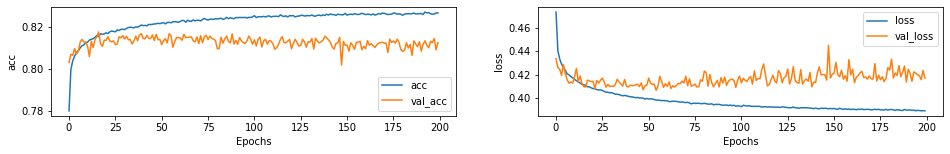

In [13]:
plt.figure(figsize=(16,2))
plt.subplot(1,2,1)
plot_graphs(history, 'acc')
plt.subplot(1,2,2)
plot_graphs(history, 'loss')

# 3. test

133992/133992 [==============================] - 9s 70us/sample - loss: 0.4088 - acc: 0.8179 - binary_crossentropy: 0.4088
Test Accuracy: [0.40883931583970745, 0.81794435, 0.40883905]
              precision    recall  f1-score   support

           0       0.85      0.78      0.81     66996
           1       0.79      0.86      0.83     66996

    accuracy                           0.82    133992
   macro avg       0.82      0.82      0.82    133992
weighted avg       0.82      0.82      0.82    133992

rf auc : 0.897000624299981


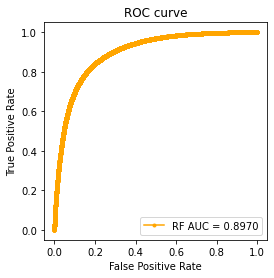

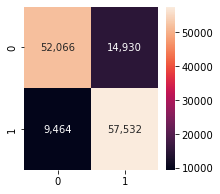

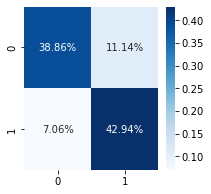

In [14]:
test_acc = model_2_1D.evaluate(X_test, y_test)
print('Test Accuracy: {}'.format(test_acc))

# prediction
y_pred = [1 if i>=0.5 else 0 for i in model_2_1D.predict(X_test)]
print(classification_report(y_test, y_pred))
# AUC
probs = model_2_1D.predict(X_test)
rf_auc = roc_auc_score(y_test, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model_2_1D
rf_fpr, rf_tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()

In [ ]:
# Calling `save('my_model.h5')` creates a h5 file `my_model.h5`.
model_2_1D.save("compareModel/2019Bioinformatics_DeepMSPeptide/2021KSBi_DeepMSpeptide.h5")

In [10]:
# It can be used to reconstruct the model identically.
model_2_1D_re = keras.models.load_model("compareModel/2019Bioinformatics_DeepMSPeptide/2021KSBi_DeepMSpeptide.h5")

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


133992/133992 [==============================] - 10s 73us/sample - loss: 0.4088 - acc: 0.8179 - binary_crossentropy: 0.4088
Test Accuracy: [0.40883931583970745, 0.81794435, 0.40883905]
              precision    recall  f1-score   support

           0       0.85      0.78      0.81     66996
           1       0.79      0.86      0.83     66996

    accuracy                           0.82    133992
   macro avg       0.82      0.82      0.82    133992
weighted avg       0.82      0.82      0.82    133992

rf auc : 0.897000624299981


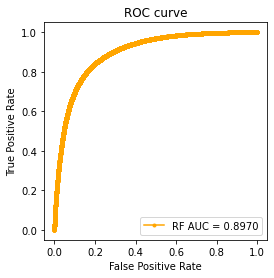

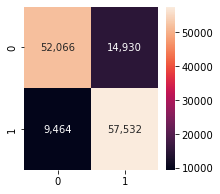

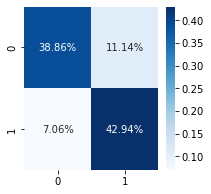

In [12]:
test_acc = model_2_1D_re.evaluate(X_test, y_test)
print('Test Accuracy: {}'.format(test_acc))

# prediction
y_pred = [1 if i>=0.5 else 0 for i in model_2_1D_re.predict(X_test)]
print(classification_report(y_test, y_pred))
# AUC
probs = model_2_1D_re.predict(X_test)
rf_auc = roc_auc_score(y_test, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model_2_1D_re
rf_fpr, rf_tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()

In [14]:
np.save('compareModel/2019Bioinformatics_DeepMSPeptide/fpr.npy', rf_fpr)
np.save('compareModel/2019Bioinformatics_DeepMSPeptide/tpr.npy', rf_tpr)

# TPR 99% DB size

# others

In [18]:
peps = pd.read_csv('Archive_noPTM/211018MS2real_problem_possibility.csv')

In [19]:
predict_label = peps.ID.values
Xs = peps.PEP.values

max_len=81
aa_dict={'A':1,'R':2,'N':3,'D':4,'C':5,'Q':6,'E':7,'G':8,'H':9,'I':10,'L':11,'K':12,'M':13,'F':14,
    'P':15,'O':16,'S':17,'U':18,'T':19,'W':20,'Y':21,'V':22}
pep_codes=[]
newLines = []
for pep in Xs:
    if not len(pep) > max_len:
        current_pep=[]
        for aa in pep:
            current_pep.append(aa_dict[aa])
        pep_codes.append(current_pep)
        newLines.extend([pep])
predict_data = keras.preprocessing.sequence.pad_sequences(pep_codes, value=0, padding='post', maxlen=max_len)

test_acc = model_2_1D.evaluate(predict_data, predict_label)
y_prob = model_2_1D.predict(predict_data)

4482/4482 [==============================] - 1s 112us/sample - loss: 0.2645 - acc: 0.8773 - binary_crossentropy: 0.2645


Test Accuracy: [0.26453991788524645, 0.8772869, 0.26453996]
              precision    recall  f1-score   support

           0       1.00      0.88      0.93      4482
           1       0.00      0.00      0.00         0

    accuracy                           0.88      4482
   macro avg       0.50      0.44      0.47      4482
weighted avg       1.00      0.88      0.93      4482



/home/bis/miniconda3/envs/TF1.14/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bis/miniconda3/envs/TF1.14/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bis/miniconda3/envs/TF1.14/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


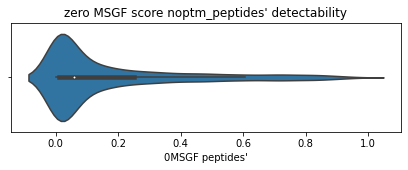

In [24]:
print('Test Accuracy: {}'.format(test_acc))

# prediction
y_pred = [1 if i>=0.5 else 0 for i in model_2_1D.predict(predict_data)]
print(classification_report(predict_label, y_pred))

plt.figure(figsize=(7,2))
sns.violinplot(y_prob.reshape(-1))
plt.title('zero MSGF score noptm_peptides\' detectability')
plt.xlabel('0MSGF peptides\'')
plt.show()

# check bias

In [27]:
file_path = 'compareModel/2019Bioinformatics_DeepMSPeptide/DeepMSPeptide/'
args = file_path + 'inputExample.txt'

print('Loading model...')
model_2_1D2 = keras.models.load_model(file_path + 'model_2_1D.h5')
print(model_2_1D2.summary())

model_2_1D2.get_layer(index=0).set_weights(
    [tf.keras.initializers.glorot_uniform(seed=7)(shape=(23,50)).numpy()])
model_2_1D2.get_layer(index=1).set_weights([])
model_2_1D2.get_layer(index=2).set_weights(
    [tf.keras.initializers.glorot_uniform(seed=7)(shape=(3,50,128)).numpy(),
     np.zeros(128,)])
model_2_1D2.get_layer(index=3).set_weights(
    [tf.keras.initializers.glorot_uniform(seed=7)(shape=(2,128,64)).numpy(),
    np.zeros(64,)])
model_2_1D2.get_layer(index=4).set_weights([])
model_2_1D2.get_layer(index=5).set_weights(
    [tf.keras.initializers.glorot_uniform(seed=7)(shape=(64,64)).numpy(),
    np.zeros(64,)])
model_2_1D2.get_layer(index=6).set_weights([])
model_2_1D2.get_layer(index=7).set_weights([])
model_2_1D2.get_layer(index=8).set_weights(
    [tf.keras.initializers.glorot_uniform(seed=7)(shape=(64,1)).numpy(),
    np.zeros(1,)])
model_2_1D2.get_layer(index=9).set_weights([])

Loading model...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 81, 50)            1150      
_________________________________________________________________
dropout_2 (Dropout)          (None, 81, 50)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 81, 128)           19328     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 80, 64)            16448     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 6

In [28]:
history2 = model_2_1D2.fit(X_train, y_train, epochs=200, 
                    batch_size=100,
                    validation_data=(X_val, y_val))

Train on 543516 samples, validate on 135880 samples
Epoch 1/200
543516/543516 [==============================] - 85s 156us/sample - loss: 0.4764 - acc: 0.7779 - binary_crossentropy: 0.4764 - val_loss: 0.4483 - val_acc: 0.7941 - val_binary_crossentropy: 0.4483
Epoch 2/200
543516/543516 [==============================] - 86s 158us/sample - loss: 0.4422 - acc: 0.7987 - binary_crossentropy: 0.4422 - val_loss: 0.4341 - val_acc: 0.8024 - val_binary_crossentropy: 0.4341
Epoch 3/200
543516/543516 [==============================] - 86s 159us/sample - loss: 0.4339 - acc: 0.8023 - binary_crossentropy: 0.4339 - val_loss: 0.4334 - val_acc: 0.8029 - val_binary_crossentropy: 0.4334
Epoch 4/200
543516/543516 [==============================] - 86s 159us/sample - loss: 0.4294 - acc: 0.8057 - binary_crossentropy: 0.4294 - val_loss: 0.4288 - val_acc: 0.8056 - val_binary_crossentropy: 0.4288
Epoch 5/200
543516/543516 [==============================] - 84s 155us/sample - loss: 0.4263 - acc: 0.8077 - binary_

Epoch 40/200
543516/543516 [==============================] - 87s 159us/sample - loss: 0.4013 - acc: 0.8206 - binary_crossentropy: 0.4013 - val_loss: 0.4168 - val_acc: 0.8123 - val_binary_crossentropy: 0.4168
Epoch 41/200
543516/543516 [==============================] - 84s 155us/sample - loss: 0.4006 - acc: 0.8213 - binary_crossentropy: 0.4006 - val_loss: 0.4269 - val_acc: 0.8078 - val_binary_crossentropy: 0.4269
Epoch 42/200
543516/543516 [==============================] - 86s 158us/sample - loss: 0.4003 - acc: 0.8215 - binary_crossentropy: 0.4003 - val_loss: 0.4154 - val_acc: 0.8132 - val_binary_crossentropy: 0.4154
Epoch 43/200
543516/543516 [==============================] - 86s 157us/sample - loss: 0.4003 - acc: 0.8208 - binary_crossentropy: 0.4003 - val_loss: 0.4137 - val_acc: 0.8144 - val_binary_crossentropy: 0.4137
Epoch 44/200
543516/543516 [==============================] - 84s 154us/sample - loss: 0.4001 - acc: 0.8211 - binary_crossentropy: 0.4001 - val_loss: 0.4167 - val_a

543516/543516 [==============================] - 85s 157us/sample - loss: 0.3908 - acc: 0.8260 - binary_crossentropy: 0.3908 - val_loss: 0.4295 - val_acc: 0.8092 - val_binary_crossentropy: 0.4295
Epoch 119/200
543516/543516 [==============================] - 86s 158us/sample - loss: 0.3908 - acc: 0.8258 - binary_crossentropy: 0.3908 - val_loss: 0.4152 - val_acc: 0.8139 - val_binary_crossentropy: 0.4152
Epoch 120/200
543516/543516 [==============================] - 83s 153us/sample - loss: 0.3906 - acc: 0.8258 - binary_crossentropy: 0.3906 - val_loss: 0.4177 - val_acc: 0.8135 - val_binary_crossentropy: 0.4177
Epoch 121/200
543516/543516 [==============================] - 85s 157us/sample - loss: 0.3905 - acc: 0.8260 - binary_crossentropy: 0.3905 - val_loss: 0.4202 - val_acc: 0.8105 - val_binary_crossentropy: 0.4202
Epoch 122/200
543516/543516 [==============================] - 86s 157us/sample - loss: 0.3909 - acc: 0.8258 - binary_crossentropy: 0.3909 - val_loss: 0.4129 - val_acc: 0.814

543516/543516 [==============================] - 86s 157us/sample - loss: 0.3868 - acc: 0.8276 - binary_crossentropy: 0.3868 - val_loss: 0.4198 - val_acc: 0.8119 - val_binary_crossentropy: 0.4198
Epoch 197/200
543516/543516 [==============================] - 83s 153us/sample - loss: 0.3869 - acc: 0.8279 - binary_crossentropy: 0.3869 - val_loss: 0.4192 - val_acc: 0.8145 - val_binary_crossentropy: 0.4192
Epoch 198/200
543516/543516 [==============================] - 86s 158us/sample - loss: 0.3874 - acc: 0.8275 - binary_crossentropy: 0.3874 - val_loss: 0.4215 - val_acc: 0.8109 - val_binary_crossentropy: 0.4215
Epoch 199/200
543516/543516 [==============================] - 85s 157us/sample - loss: 0.3870 - acc: 0.8276 - binary_crossentropy: 0.3870 - val_loss: 0.4197 - val_acc: 0.8137 - val_binary_crossentropy: 0.4197
Epoch 200/200
543516/543516 [==============================] - 84s 154us/sample - loss: 0.3871 - acc: 0.8278 - binary_crossentropy: 0.3871 - val_loss: 0.4199 - val_acc: 0.813

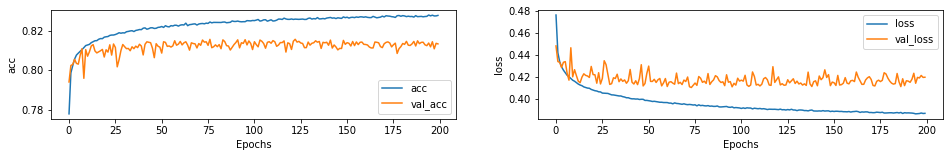

In [29]:
plt.figure(figsize=(16,2))
plt.subplot(1,2,1)
plot_graphs(history2, 'acc')
plt.subplot(1,2,2)
plot_graphs(history2, 'loss')

133992/133992 [==============================] - 11s 81us/sample - loss: 0.4018 - acc: 0.8234 - binary_crossentropy: 0.4018
Test Accuracy: [0.4017712440435349, 0.82335514, 0.40177077]
              precision    recall  f1-score   support

           0       0.84      0.80      0.82     66996
           1       0.81      0.84      0.83     66996

    accuracy                           0.82    133992
   macro avg       0.82      0.82      0.82    133992
weighted avg       0.82      0.82      0.82    133992

rf auc : 0.8999477677888996


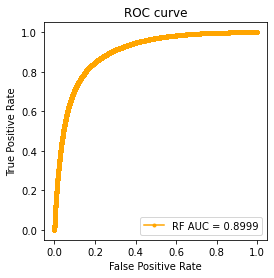

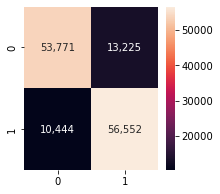

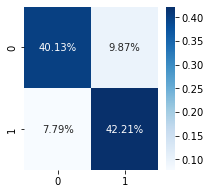

In [30]:
test_acc = model_2_1D2.evaluate(X_test, y_test)
print('Test Accuracy: {}'.format(test_acc))

# prediction
y_pred = [1 if i>=0.5 else 0 for i in model_2_1D2.predict(X_test)]
print(classification_report(y_test, y_pred))
# AUC
probs = model_2_1D2.predict(X_test)
rf_auc = roc_auc_score(y_test, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model_2_1D2
rf_fpr, rf_tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()